In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [2]:

def obtain_metrics(model, x, y, threshold):
    y_pred = model.predict(x)
    y_pred_binary = []
    
    for pred in y_pred:
        if pred > threshold:
            y_pred_binary.append(1)
        else:
            y_pred_binary.append(0)

    conf = confusion_matrix(y, y_pred_binary)
    tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
    accuracy = round((tp + tn) / (fn + fp + tp + tn), 2) #Exactitud, porcentaje de predicciones correctas
    precision = round(tp / (fp + tp), 2) #Precisión, porcentaje de predicciones positivas correctas
    specifity = round(tn / (tn + fn), 2) #Especificidad, porcentaje de casos negativos detectados correctamente
    recall = round(tp / (tp + fn), 2) # sensibilidad, porcentaje de casos positivos detectados
    true_negative_rate = round(tn / (tn + fp), 2)
    F1_score = round(precision * 2 * recall / (precision + recall), 2)

    return accuracy, precision, specifity, recall, true_negative_rate, F1_score, y_pred

    
def metrics(x_train, y_train, x_test, y_test, model, threshold=0.5, plot=False, save_plot=False, name='', expand=False):
    '''
    x_test: Dataset
    y_test: Dataset
    model: Modelo
    Threshold: Umbral para la clasificación
    save_plot: Guardar gráfico de AUC
    name: nombre del archivo para guardar
    '''
    if expand:
        x_test = np.expand_dims(x_test, axis=1)
        x_train = np.expand_dims(x_train, axis=1)

    (test_accuracy, 
    test_precision, 
    test_specifity, 
    test_recall, 
    test_true_negative_rate, 
    test_F1_score, 
    y_pred) = obtain_metrics(model, x_test, y_test, threshold)

    (train_accuracy,
     train_precision, 
     train_specifity, 
     train_recall, 
     train_true_negative_rate, 
     train_F1_score, _) = obtain_metrics(model, x_train, y_train, threshold)
    
    if plot:
        nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
        auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
        fig, ax1 = plt.subplots(1, 1, figsize=(30,15))
        ax1.plot(nn_fpr_keras, nn_tpr_keras, label='ROC (auc = %0.3f)' % auc_keras)
        ax1.set_title('ROC', fontsize=22)
        ax1.set_xlabel('False positive rate', fontsize=18)
        ax1.set_ylabel('True positive rate', fontsize=18)

        ticks = np.arange(0, 1.05, 0.05)
        ax1.set_yticks(ticks)
        ax1.set_xticks(ticks)
        ax1.set_ylim((0,1))
        ax1.set_xlim((0,1))
        ax1.plot(ticks, ticks)
        ax1.plot(nn_fpr_keras, nn_thresholds_keras, label='Thresholds')
        # ax1.set_xticklabels(range(0, len(epochs)), fontsize=16)
        # ax1.set_yticklabels(ticks, fontsize=16)
        ax1.legend(fontsize=18)
        ax1.grid()
        plt.show()
        
        
        if save_plot:
            plt.savefig(name)
    
    print(f'Exactitud: {train_accuracy} / {test_accuracy}')
    print(f'Precisión: {train_precision} / {test_precision}')
    print(f'Especificidad: {train_specifity} / {test_specifity}')
    print(f'Sensibilidad: {train_recall} / {test_recall}')
    print(f'true_negative_rate: {train_true_negative_rate} / {test_true_negative_rate}')
    print(f'F1 - Score: {train_F1_score} / {test_F1_score}')

    return train_recall, test_recall


def load_dataset(meld_name, enterface_name, delete):
    '''
    meld_name: Directorio del dataset de meld
    enterface_name: Directorio del dataset de enterface
    delete: Lista de features a eliminar (lista con los índices)
    '''

    meld = np.load(meld_name, allow_pickle=True)
    meld_x = meld[()]['x']
    meld_y = meld[()]['y']

    enterface = np.load(enterface_name, allow_pickle=True)
    enterface_x = enterface[()]['x']
    enterface_y = enterface[()]['y']

    full_x = np.concatenate((enterface_x, meld_x), axis=0)
    full_y = np.concatenate((enterface_y, meld_y), axis=0)

    enterface_x = np.delete(enterface_x, delete,1)
    meld_x = np.delete(meld_x, delete, 1)
    full_x = np.delete(full_x, delete, 1)

    return full_x, full_y, meld_x, meld_y, enterface_x, enterface_y

def plot_training(history):
    loss = [1]
    loss.extend(history.history['loss'])


    val_loss = [1]
    val_loss.extend(history.history['val_loss'])

    epochs = list(range(0, len(loss)))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,15))

    ax1.plot(epochs, loss, 'r', label='Training loss')
    ax1.plot([epoch+0.5 for epoch in epochs], val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss Model_1', fontsize=22)
    ax1.set_xlabel('Epochs', fontsize=18)
    ax1.set_ylabel('Loss', fontsize=18)

    ax1.legend(fontsize=18)
    ax1.grid()

    accuracy = [0]
    accuracy.extend(history.history['recall'])
    val_accuracy = [0]
    val_accuracy.extend(history.history['val_recall'])


    ax2.plot(epochs, accuracy, 'r', label='Training recall')
    ax2.plot([epoch+0.5 for epoch in epochs], val_accuracy, 'b', label='Validation recall')
    ax2.set_title('recall')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('recall')
    ax2.grid()
    plt.show()

    
def f_score(precision, recall, beta):
    beta_square = beta**2
    f = (1+beta_square) * precision * recall / ((beta_square* precision) + recall)
    return f

In [3]:

dataset = np.load('datasets/dataset_no_outliers.npy', allow_pickle=True)
X = dataset[()]['x']
Y = dataset[()]['y']
train_x, test_x, train_y, test_y = train_test_split(np.array(X), np.array(Y), test_size=0.15, random_state=9)

#### Red convolucional

In [4]:
from keras.models import Sequential
from keras.layers import *
from keras import callbacks

In [35]:
def create_model_CNN(input_shape):
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model = Sequential([

        # Conv1D(filters = 64, kernel_size = 7, activation = 'relu', padding = 'same', input_shape =(1 ,120), kernel_regularizer=keras.regularizers.l2(0.01)),
        Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same', input_shape =input_shape),
        Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same'),


        Conv1D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
        Conv1D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),

        
        Conv1D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),
        Conv1D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),


        Flatten(),
        Dense(units = 64, activation = 'relu'),

        Dense(units = 32, activation = 'relu'),

        Dense(units = 1, activation = 'sigmoid')])
        
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[keras.metrics.Recall()])
    
    return model
def fit_cnn(train_x, train_y, test_x, test_y, epochs=100, patience=5, verbose=1, save=False, name='./modelos/CNN'):
    '''
    verbose: 0= silencio, 1= una linea, 2= una linea por epoch
    '''
    train_x = np.expand_dims(train_x, axis=1)
    test_x = np.expand_dims(test_x, axis=1)
    input_shape = train_x.shape[1:]
    model = create_model_CNN(input_shape)
    model.build()
    if verbose != 0:
        model.summary()

    earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = patience, 
                                        restore_best_weights = True)

    history = model.fit(train_x, train_y, validation_data=(test_x,test_y), epochs=100, callbacks=[earlystopping], verbose=verbose)
    if save:
        model.save_weights(name)
    return model, history


In [36]:
cnn_model, cnn_history = fit_cnn(train_x, train_y, test_x, test_y, epochs=100, patience=5, verbose=1, save=False, name='./modelos/CNN')



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 1, 64)             7936      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1, 64)             12352     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1, 128)            24704     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1, 128)            49280     
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1, 256)            98560     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 1, 256)            196864    
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)              

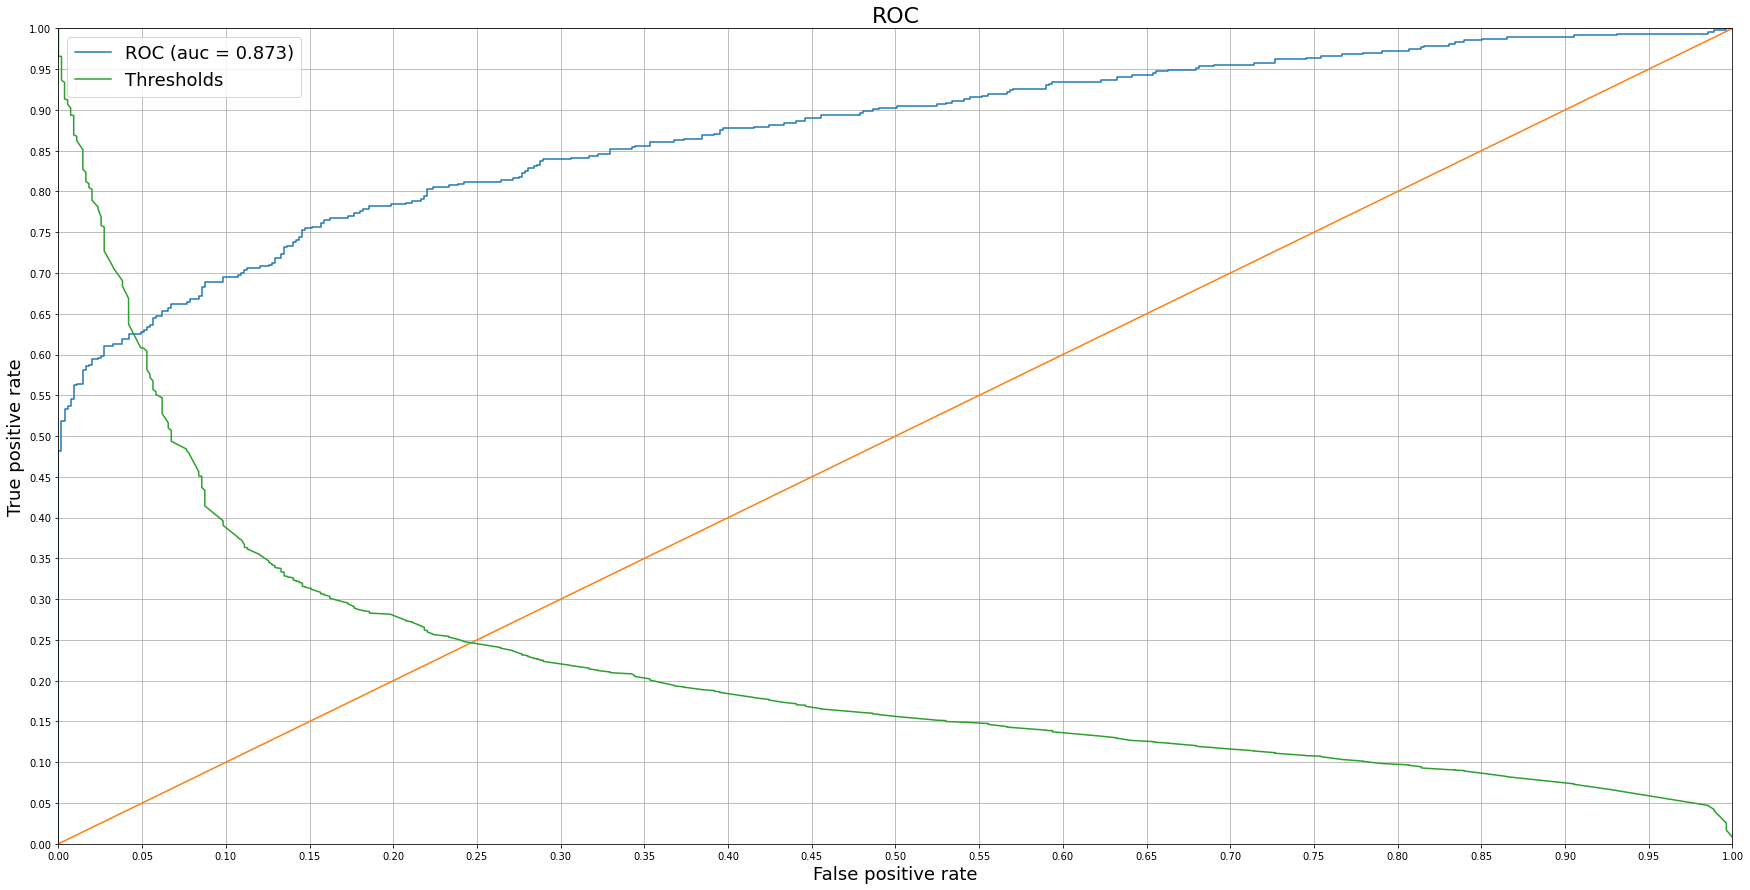

Exactitud: 0.8566768160069596 / 0.8062622309197651
Precisión: 0.9402985074626866 / 0.8939828080229226
Especificidad: 0.813130477922937 / 0.7607726597325408
Sensibilidad: 0.7237839159129797 / 0.6596194503171248
true_negative_rate: 0.9631733594515182 / 0.9326047358834244
F1 - Score: 0.8179558011049725 / 0.7591240875912408


In [85]:
metrics(x_train, y_train, x_test, y_test, cnn_model, threshold=0.5, plot=True, save_plot=False, name='', expand=True)


## MLP Classifier

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import ast

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [9]:
clf = MLPClassifier(random_state=1)
parameters = {
    'hidden_layer_sizes':[3, 4, 5, 6, 7 ,8 ,9, 10, 11, 12, 13, 14,15, 16, 17, 18, 19, 20],
    'activation': ['identity', 'logistic', 'tan', 'relu'],
    'solver':['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000],
}

In [171]:
search = GridSearchCV(estimator=clf, param_grid=parameters, scoring=('precision', 'recall'), refit=False, verbose=2, n_jobs=6, cv=10)
search.fit(X, Y)
results = pd.DataFrame(search.cv_results_)


Fitting 10 folds for each of 648 candidates, totalling 6480 fits


GridSearchCV(cv=10, estimator=MLPClassifier(random_state=1), n_jobs=6,
             param_grid={'activation': ['identity', 'logistic', 'tan', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                                13, 14, 15, 16, 17, 18, 19,
                                                20],
                         'max_iter': [1000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             refit=False, scoring=('precision', 'recall'), verbose=2)

In [11]:
results['f0,5_score'] = results.apply(lambda row: f_score(row.mean_test_precision, row.mean_test_recall, 0.5), axis=1)
results['f2_score'] = results.apply(lambda row: f_score(row.mean_test_precision, row.mean_test_recall, 2), axis=1)
results['f1_score'] = results.apply(lambda row: f_score(row.mean_test_precision, row.mean_test_recall, 1), axis=1)
results['f1,5_score'] = results.apply(lambda row: f_score(row.mean_test_precision, row.mean_test_recall, 1.5), axis=1)
results = results.round(2)

In [12]:
best = results.sort_values(by=[ 'f0,5_score', 'mean_test_recall', 'f2_score', 'mean_test_precision'], ascending=False)[['f0,5_score','f1_score', 'f1,5_score', 'f2_score', 'mean_test_recall', 'mean_test_precision']].head(5)
print(best)
index = best.head(1).index.item()
results['params'].iloc[index]

     f0,5_score  f1_score  f1,5_score  f2_score  mean_test_recall  mean_test_precision
165     0.89       0.79       0.73       0.71          0.66               0.97        
189     0.89       0.79       0.73       0.71          0.66               0.97        
270     0.89       0.79       0.73       0.71          0.66               0.97        
282     0.89       0.79       0.73       0.71          0.66               0.97        
288     0.89       0.79       0.73       0.71          0.66               0.97        


"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 4, 'max_iter': 1000, 'solver': 'lbfgs'}"

In [13]:
best = results.sort_values(by=[ 'f1_score', 'f2_score', 'mean_test_recall', 'mean_test_precision'], ascending=False)[['f0,5_score','f1_score', 'f1,5_score', 'f2_score', 'mean_test_recall', 'mean_test_precision']].head(5)
print(best)
index = best.head(1).index.item()
results['params'].iloc[index]

     f0,5_score  f1_score  f1,5_score  f2_score  mean_test_recall  mean_test_precision
528     0.86       0.81       0.78       0.77          0.74               0.89        
582     0.86       0.81       0.78       0.77          0.74               0.89        
636     0.86       0.81       0.78       0.77          0.74               0.89        
494     0.82       0.80       0.78       0.77          0.76               0.84        
530     0.82       0.80       0.78       0.77          0.76               0.84        


"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 17, 'max_iter': 1000, 'solver': 'lbfgs'}"

In [14]:
best = results.sort_values(by=[ 'f1,5_score' , 'mean_test_precision', 'mean_test_recall'], ascending=False)[['f0,5_score','f1_score', 'f1,5_score', 'f2_score', 'mean_test_recall', 'mean_test_precision']].head(5)
print(best)
index = best.head(1).index.item()
results['params'].iloc[index]

     f0,5_score  f1_score  f1,5_score  f2_score  mean_test_recall  mean_test_precision
515     0.78       0.79       0.80       0.80          0.81               0.77        
569     0.78       0.79       0.80       0.80          0.81               0.77        
623     0.78       0.79       0.80       0.80          0.81               0.77        
29      0.80       0.79       0.79       0.79          0.79               0.80        
83      0.80       0.79       0.79       0.79          0.79               0.80        


"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 12, 'max_iter': 1000, 'solver': 'adam'}"

In [15]:
best = results.sort_values(by=['f2_score', 'f0,5_score', 'mean_test_recall', 'mean_test_precision'], ascending=False)[['f0,5_score','f1_score', 'f1,5_score', 'f2_score', 'mean_test_recall', 'mean_test_precision']].head(5)
print(best)
index = best.head(1).index.item()
results['params'].iloc[index]

     f0,5_score  f1_score  f1,5_score  f2_score  mean_test_recall  mean_test_precision
515     0.78       0.79       0.80        0.8          0.81               0.77        
569     0.78       0.79       0.80        0.8          0.81               0.77        
623     0.78       0.79       0.80        0.8          0.81               0.77        
50      0.77       0.78       0.79        0.8          0.81               0.76        
104     0.77       0.78       0.79        0.8          0.81               0.76        


"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 12, 'max_iter': 1000, 'solver': 'adam'}"

In [179]:
results.to_csv('MLPC_1.csv')

In [182]:
a = results['params'].iloc[515]
# a = ast.literal_eval(a)
for key in a:
    if key != 'hidden_layer_sizes':
        a[key] = [a[key]]

In [183]:
hidden_layer = [[i+12]* (n+1) for n in range(10) for i in range(20)]
print(len(hidden_layer))


200


In [184]:
a['hidden_layer_sizes'] = hidden_layer

In [185]:
clf = MLPClassifier(random_state=1)
second_search = GridSearchCV(estimator=clf, param_grid=a, scoring=('precision', 'recall'), refit=False, verbose=2, n_jobs=6, cv=10)
second_search.fit(train_x, train_y)
second_results = pd.DataFrame(second_search.cv_results_)
second_results.head()

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_max_iter,param_solver,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,split5_test_precision,split6_test_precision,split7_test_precision,split8_test_precision,split9_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,split5_test_recall,split6_test_recall,split7_test_recall,split8_test_recall,split9_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,4.597,0.454,0.006,1.002e-03,relu,0.0,[12],1000,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.856,0.752,0.776,0.897,0.896,0.929,0.877,0.692,0.701,0.951,0.833,0.090,181,0.710,0.826,0.749,0.731,0.746,0.665,0.686,0.808,0.862,0.638,0.742,0.069,23
1,4.569,0.729,0.006,3.289e-03,relu,0.0,[13],1000,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.883,0.917,0.773,0.794,0.824,0.916,0.766,0.859,0.868,0.879,0.848,0.053,162,0.722,0.695,0.775,0.784,0.784,0.656,0.766,0.695,0.731,0.677,0.729,0.045,48
2,1.961,0.532,0.005,1.588e-03,relu,0.0,[14],1000,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.860,0.879,0.935,0.830,0.887,0.898,0.804,0.897,0.715,0.708,0.841,0.074,171,0.731,0.716,0.644,0.760,0.751,0.713,0.737,0.680,0.865,0.847,0.744,0.065,21
3,3.558,0.720,0.005,9.787e-04,relu,0.0,[15],1000,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.819,0.947,0.712,0.811,0.931,0.872,0.723,0.778,0.921,0.917,0.843,0.083,167,0.743,0.701,0.808,0.796,0.722,0.695,0.814,0.775,0.662,0.692,0.741,0.052,27
4,4.433,0.846,0.006,1.432e-03,relu,0.0,[16],1000,adam,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.800,0.790,0.849,0.835,0.901,0.823,0.834,0.769,0.842,0.907,0.835,0.042,179,0.776,0.811,0.725,0.787,0.737,0.725,0.737,0.787,0.784,0.698,0.757,0.035,10


In [16]:
second_results['f0,5_score'] = second_results.apply(lambda row: f_score(row.mean_test_precision, row.mean_test_recall, 0.5), axis=1)
second_results['f2_score'] = second_results.apply(lambda row: f_score(row.mean_test_precision, row.mean_test_recall, 2), axis=1)
second_results['f1_score'] = second_results.apply(lambda row: f_score(row.mean_test_precision, row.mean_test_recall, 1), axis=1)
second_results['f1,5_score'] = second_results.apply(lambda row: f_score(row.mean_test_precision, row.mean_test_recall, 1.5), axis=1)
second_results = second_results.round(2)


In [17]:
best = second_results.sort_values(by=[ 'f0,5_score', 'mean_test_recall', 'f2_score', 'mean_test_precision'], ascending=False)[['f0,5_score','f1_score', 'f1,5_score', 'f2_score', 'mean_test_recall', 'mean_test_precision']].head(5)
print(best)
index = best.head(1).index.item()
print(second_results['params'].iloc[index])


     f0,5_score  f1_score  f1,5_score  f2_score  mean_test_recall  mean_test_precision
124     0.87       0.80       0.76       0.74          0.70               0.92        
102     0.87       0.79       0.75       0.73          0.69               0.93        
156     0.87       0.79       0.74       0.72          0.68               0.93        
162     0.87       0.79       0.74       0.72          0.68               0.93        
182     0.87       0.79       0.74       0.72          0.68               0.93        
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': [16, 16, 16, 16, 16, 16, 16], 'max_iter': 1000, 'solver': 'adam'}


In [18]:
best = second_results.sort_values(by=[ 'f1_score', 'f2_score', 'mean_test_recall', 'mean_test_precision'], ascending=False)[['f0,5_score','f1_score', 'f1,5_score', 'f2_score', 'mean_test_recall', 'mean_test_precision']].head(5)
print(best)
index = best.head(1).index.item()
print(second_results['params'].iloc[index])


    f0,5_score  f1_score  f1,5_score  f2_score  mean_test_recall  mean_test_precision
4      0.82        0.8       0.78       0.77          0.76               0.84        
79     0.83        0.8       0.78       0.77          0.75               0.85        
14     0.83        0.8       0.77       0.76          0.74               0.86        
23     0.83        0.8       0.77       0.76          0.74               0.86        
73     0.83        0.8       0.77       0.76          0.74               0.86        
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': [16], 'max_iter': 1000, 'solver': 'adam'}


In [19]:
best = second_results.sort_values(by=[ 'f1,5_score' , 'mean_test_precision', 'mean_test_recall'], ascending=False)[['f0,5_score','f1_score', 'f1,5_score', 'f2_score', 'mean_test_recall', 'mean_test_precision']].head(5)
print(best)
index = best.head(1).index.item()
print(second_results['params'].iloc[index])


    f0,5_score  f1_score  f1,5_score  f2_score  mean_test_recall  mean_test_precision
5      0.80       0.79       0.79       0.79          0.78               0.81        
76     0.77       0.78       0.79       0.79          0.80               0.76        
79     0.83       0.80       0.78       0.77          0.75               0.85        
4      0.82       0.80       0.78       0.77          0.76               0.84        
22     0.81       0.79       0.78       0.77          0.76               0.83        
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': [17], 'max_iter': 1000, 'solver': 'adam'}


In [20]:
best = second_results.sort_values(by=['f2_score', 'f0,5_score', 'mean_test_recall', 'mean_test_precision'], ascending=False)[['f0,5_score','f1_score', 'f1,5_score', 'f2_score', 'mean_test_recall', 'mean_test_precision']].head(5)
print(best)
index = best.head(1).index.item()
print(second_results['params'].iloc[index])


    f0,5_score  f1_score  f1,5_score  f2_score  mean_test_recall  mean_test_precision
5      0.80       0.79       0.79       0.79          0.78               0.81        
76     0.77       0.78       0.79       0.79          0.80               0.76        
19     0.77       0.78       0.78       0.79          0.79               0.77        
13     0.81       0.79       0.78       0.78          0.77               0.82        
9      0.79       0.78       0.78       0.78          0.77               0.80        
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': [17], 'max_iter': 1000, 'solver': 'adam'}


In [21]:
second_results.iloc[index]

Unnamed: 0                                                                  5
mean_fit_time                                                            2.70
std_fit_time                                                             0.21
mean_score_time                                                          0.00
std_score_time                                                           0.00
param_activation                                                         relu
param_alpha                                                              0.00
param_hidden_layer_sizes                                                 [17]
param_max_iter                                                           1000
param_solver                                                             adam
params                      {'activation': 'relu', 'alpha': 0.0001, 'hidde...
split0_test_precision                                                    0.61
split1_test_precision                                           

In [206]:
params = second_results['params'].iloc[80]
clf = MLPClassifier(random_state=1, **params)
clf.fit(train_x, train_y)
metrics(train_x, train_y, test_x, test_y, clf, threshold=0.5, plot=False, save_plot=False, name='', expand=False)

Exactitud: 0.82 / 0.83
Precisión: 0.93 / 0.92
Especificidad: 0.75 / 0.78
Sensibilidad: 0.69 / 0.72
true_negative_rate: 0.95 / 0.94
F1 - Score: 0.79 / 0.81


(0.69, 0.72)

In [193]:
second_results.to_csv('MLPC_2.csv')

In [23]:
less_std = second_results.sort_values(by=['std_test_recall'], ascending=True)[['f0,5_score','f1_score', 'f1,5_score', 'f2_score', 'mean_test_recall', 'mean_test_precision', 'std_test_recall']].head(5)
print(less_std)

     f0,5_score  f1_score  f1,5_score  f2_score  mean_test_recall  mean_test_precision  std_test_recall
83      0.85       0.79       0.76       0.74          0.71               0.90               0.01      
82      0.86       0.78       0.75       0.73          0.69               0.91               0.01      
142     0.85       0.78       0.74       0.72          0.69               0.90               0.02      
157     0.85       0.79       0.76       0.74          0.71               0.89               0.02      
155     0.86       0.79       0.75       0.73          0.70               0.91               0.02      


In [25]:
less_std = results.sort_values(by=['std_test_recall'], ascending=True)[['f0,5_score','f1_score', 'f1,5_score', 'f2_score', 'mean_test_recall', 'mean_test_precision', 'std_test_recall']].head(5)
print(less_std)

     f0,5_score  f1_score  f1,5_score  f2_score  mean_test_recall  mean_test_precision  std_test_recall
0       0.84       0.80       0.78       0.77          0.75               0.86               0.02      
90      0.84       0.80       0.78       0.77          0.75               0.86               0.02      
87      0.84       0.80       0.78       0.77          0.75               0.86               0.02      
84      0.84       0.80       0.78       0.77          0.75               0.86               0.02      
320     0.87       0.79       0.75       0.73          0.69               0.93               0.02      


## Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [100]:
clf = RandomForestClassifier(random_state=1)
parameters = {'bootstrap': [True, False],
            'criterion':["gini", "entropy"],
            'max_depth': [10],
            'max_features': ['sqrt', 0.8, 0.6],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [1600, 1800, 2000],
            'n_jobs': [6]
            }

In [101]:
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = parameters, n_iter = 100, cv= 3, verbose=2, random_state=1, n_jobs = 6, scoring=('recall', 'precision', 'accuracy'), refit='recall')
rf_random.fit(X, Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   n_iter=100, n_jobs=6,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1600, 1800, 2000],
                                        'n_jobs': [6]},
                   random_state=1, refit='recall',
                   scoring=('recall', 'precision', 'accuracy'), verbose=2)

In [102]:
params = rf_random.best_params_
model = RandomForestClassifier(random_state=1, **params)

In [103]:

model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       n_estimators=1600, n_jobs=6, random_state=1)

In [104]:
metrics(train_x, train_y, test_x, test_y, model, threshold=0.5, plot=False, save_plot=False, name='', expand=False)

Exactitud: 0.92 / 0.85
Precisión: 1.0 / 0.91
Especificidad: 0.86 / 0.8
Sensibilidad: 0.83 / 0.76
true_negative_rate: 1.0 / 0.93
F1 - Score: 0.91 / 0.83


(0.83, 0.76)

In [105]:
df = pd.DataFrame(rf_random.cv_results_)
df.to_cas('Random_forest.csv')

In [106]:
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_jobs,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,params,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_precision,split1_test_precision,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,82.890,0.542,1.518,0.062,6,1800,2,4,sqrt,10,entropy,False,"{'n_jobs': 6, 'n_estimators': 1800, 'min_sampl...",0.704,0.715,0.715,0.711,0.005,92,0.919,0.905,0.909,0.911,0.006,35,0.821,0.820,0.821,0.821,6.277e-04,91
1,77.301,0.831,1.423,0.107,6,1600,2,2,sqrt,10,entropy,False,"{'n_jobs': 6, 'n_estimators': 1600, 'min_sampl...",0.704,0.718,0.716,0.712,0.006,74,0.921,0.909,0.914,0.914,0.005,1,0.822,0.823,0.824,0.823,1.074e-03,2
2,96.125,0.187,1.811,0.164,6,2000,2,2,sqrt,10,entropy,False,"{'n_jobs': 6, 'n_estimators': 2000, 'min_sampl...",0.703,0.718,0.715,0.712,0.006,82,0.921,0.908,0.913,0.914,0.005,4,0.821,0.822,0.823,0.822,9.124e-04,13
3,98.473,0.870,1.749,0.175,6,2000,10,1,sqrt,10,entropy,False,"{'n_jobs': 6, 'n_estimators': 2000, 'min_sampl...",0.703,0.717,0.714,0.711,0.006,92,0.921,0.907,0.912,0.913,0.006,12,0.821,0.821,0.822,0.822,4.548e-04,53
4,90.467,0.847,1.624,0.125,6,2000,2,4,sqrt,10,entropy,False,"{'n_jobs': 6, 'n_estimators': 2000, 'min_sampl...",0.703,0.715,0.715,0.711,0.006,98,0.920,0.906,0.910,0.912,0.006,28,0.821,0.820,0.822,0.821,9.520e-04,81


In [107]:
scores = cross_validate(model, X, Y, cv=10, scoring=('recall', 'precision', 'accuracy'))

In [108]:
print(scores['test_recall'].mean())
print(scores['test_recall'].std())

0.7157938225457408
0.022897106827211283
